# Load and demonstration of CIFAR-10 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
np.random.seed(42)

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'r') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

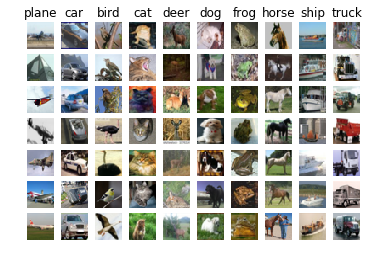

Train data shape:(3073, 9794),
Train labels shape:(9794,), 
Validation data shape:(3073, 206),
Validation labels shape:(206,),
Test data shape:(3073, 2000),
Test labels shape:(2000,),


In [2]:
from algorithms.data_utils import load_CIFAR10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_CIFAR10_data(num_training=49000, num_val=1000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = 'cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data for validation set
    mask = range(num_training, num_training + num_val)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test

def subset_classes_data(classes):
    # Subset 'plane' and 'car' classes to perform logistic regression
    idxs = np.logical_or(y_train_raw == 0, y_train_raw == 1)
    X_train = X_train_raw[idxs, :]
    y_train = y_train_raw[idxs]
    # validation set
    idxs = np.logical_or(y_val_raw == 0, y_val_raw == 1)
    X_val = X_val_raw[idxs, :]
    y_val = y_val_raw[idxs]
    # test set
    idxs = np.logical_or(y_test_raw == 0, y_test_raw == 1)
    X_test = X_test_raw[idxs, :]
    y_test = y_test_raw[idxs]
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_CIFAR10_data()
visualize_sample(X_train_raw, y_train_raw, classes)
subset_classes = ['plane', 'cat']
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = subset_classes_data(subset_classes)
X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_CIFAR10_data(X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw)

# As a sanity check, we print out th size of the training and test data dimenstion
print ("Train data shape:{},".format(X_train.shape))
print ("Train labels shape:{}, ".format(y_train.shape))
print ("Validation data shape:{},".format(X_val.shape))
print ("Validation labels shape:{},".format(y_val.shape))
print ("Test data shape:{},".format(X_test.shape))
print ("Test labels shape:{},".format(y_test.shape))

# Logistic Regression Classifier

In [7]:
from algorithms.classifiers.loss_grad_logistic import loss_grad_logistic_naive, loss_grad_logistic_vectorized
from algorithms.classifiers.linear_classifier import LinearClassifier,Logistic
import time
# using BGD algorithm
logistic = Logistic()
tic = time.time()
losses,weight = logistic.train(X_train, y_train, method='sgd', batch_size=200, learning_rate=1e-6,
              reg = 0, num_iters=1000, verbose=True, vectorized=True)
toc = time.time()
print("Traning time for BGD with vectorized version is {}".format(toc - tic))
losses[-1]

weight initialization=[[0. 0. 0. ... 0. 0. 0.]]
iteration 0/1000: loss 0.693147
iteration 100/1000: loss 0.444026
iteration 200/1000: loss 0.392270
iteration 300/1000: loss 0.388565
iteration 400/1000: loss 0.427064
iteration 500/1000: loss 0.472308
iteration 600/1000: loss 0.412075
iteration 700/1000: loss 0.393658
iteration 800/1000: loss 0.328842
iteration 900/1000: loss 0.385286
Traning time for BGD with vectorized version is 1.4277136325836182


0.33802887985092467

/Users/xueying/anaconda3/lib/python3.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


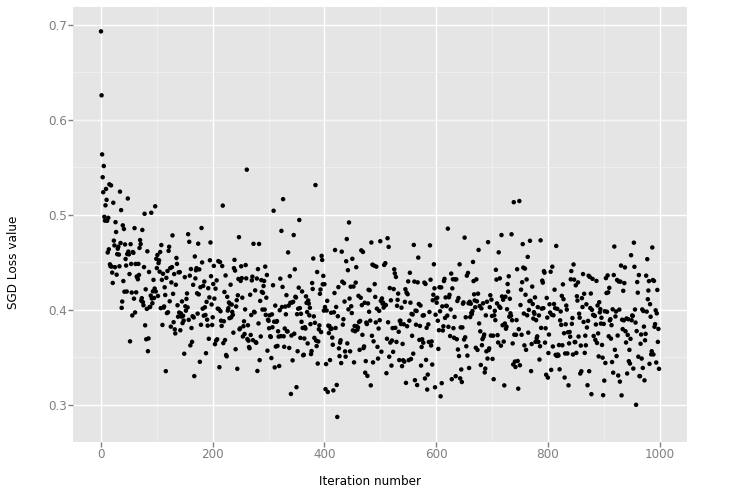

<ggplot: (2994892152)>

In [4]:
from ggplot import *
qplot(range(len(losses)), losses) + labs(x='Iteration number', y='SGD Loss value')

# Experiments - Convergence

In [5]:
def data_replication(X,y,r):
    if r==1:
        return X,y
    idx = np.random.choice(X.shape[1], int(X.shape[1]/r),replace=False)
    X = np.tile(X[:,idx], r)
    y =np.tile(y[idx], r)
    return X,y

In [6]:
loss_mtx=[]
loss_mtx2=[]
for r in [1,2,4,8]:
    loss=[]
    loss_2=[]
    X_train_r,y_train_r = data_replication(X_train,y_train,r)
    batch_size=16
    print("Batch size={}".format(batch_size))
    print("Data Replication Factor = {}".format(r))
    
    # choose a best learning rate with batch-size=16
#    d=[]
#    for learning_rate in [1e-6,5e-7]:
#        # number of iterations change accordingly to batch sizes, so that total gradient evaluations are the same for 
#        # each run
#        logistic = Logistic()
#        losses,weight = logistic.train(X_train_r, y_train_r, method='sgd', batch_size=batch_size, learning_rate=learning_rate,
#              reg = 0, num_iters=int(2**16/batch_size), verbose=True, vectorized=True)
#        # average loss over iterations
#        d.append([np.average(losses),learning_rate])
        
#    print("d={}".format(d))
#    gamma = min(d)[1]
#    print("learning rate={}".format(gamma))
    #loss.append(min(d)[0])
    for batch_size in [16,256,512,768]:
        X_train_r,y_train_r = data_replication(X_train,y_train,r)
        print("Batch size={}".format(batch_size))
        print("Data Replication Factor = {}".format(r))
        # number of iterations change accordingly to batch sizes, so that total gradient evaluations are the same for 
        # each run
        logistic = Logistic()
        losses,weight = logistic.train(X_train_r, y_train_r, method='sgd', batch_size=batch_size, learning_rate=1e-6,
              reg = 0, num_iters=int(2**16/batch_size), verbose=True, vectorized=True)

        qplot(range(len(losses)), losses) + labs(x='Iteration number', y='SGD Loss value')
        # average loss over iterations
        loss.append(np.average(losses))
        # loss function with averaged weights from iterations
        l, g = loss_grad_logistic_vectorized(np.average(np.array(weight),axis =0), X_train_r, y_train_r, reg = 0)
        loss_2.append(l)
    loss_mtx.append(loss.copy())
    loss_mtx2.append(loss_2.copy())


Batch size=16
Data Replication Factor = 1
Batch size=16
Data Replication Factor = 1
weight initialization=[[0. 0. 0. ... 0. 0. 0.]]
iteration 0/4096: loss 0.693147
iteration 100/4096: loss 0.563288
iteration 200/4096: loss 0.295554
iteration 300/4096: loss 0.446957
iteration 400/4096: loss 0.276487
iteration 500/4096: loss 0.451271
iteration 600/4096: loss 0.361476
iteration 700/4096: loss 0.763762
iteration 800/4096: loss 0.348945
iteration 900/4096: loss 0.439936
iteration 1000/4096: loss 0.395292
iteration 1100/4096: loss 0.250590
iteration 1200/4096: loss 0.485098
iteration 1300/4096: loss 0.335759
iteration 1400/4096: loss 0.309060
iteration 1500/4096: loss 0.424483
iteration 1600/4096: loss 0.428918
iteration 1700/4096: loss 0.261000
iteration 1800/4096: loss 0.269204
iteration 1900/4096: loss 0.315521
iteration 2000/4096: loss 0.421519
iteration 2100/4096: loss 0.723761
iteration 2200/4096: loss 0.178720
iteration 2300/4096: loss 0.398118
iteration 2400/4096: loss 0.343788
itera

In [7]:
loss_rate=np.array(loss_mtx).T/(np.array(loss_mtx).T[0])
loss_rate

array([[1.        , 1.        , 1.        , 1.        ],
       [1.04507027, 1.07645793, 1.19211494, 1.29356072],
       [1.08188325, 1.1411637 , 1.22465438, 1.52832141],
       [1.11435934, 1.16807491, 1.28489891, 1.56343242]])

In [8]:
loss_rate2=np.array(loss_mtx2).T/(np.array(loss_mtx2).T[0])
loss_rate2

array([[1.        , 1.        , 1.        , 1.        ],
       [1.11903549, 1.16578339, 1.29311178, 1.40299617],
       [1.16481837, 1.23301987, 1.32981161, 1.6595042 ],
       [1.19707666, 1.24939432, 1.37323993, 1.69566581]])

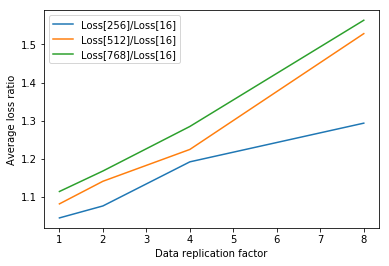

In [9]:
plt.clf()
plt.plot([1,2,4,8],loss_rate[1],label='Loss[256]/Loss[16]')
plt.plot([1,2,4,8],loss_rate[2],label='Loss[512]/Loss[16]')
plt.plot([1,2,4,8],loss_rate[3],label='Loss[768]/Loss[16]')
plt.xlabel('Data replication factor')
plt.ylabel('Average loss ratio')
plt.legend()
plt.savefig('data_replication_logistic.png', format='png', dpi=1000)

## Experiments - Stability

We first generate two training data sets that differ in only one training point.

In [14]:
X_train_1=np.append(X_train[:,-2].reshape(3073,1),X_train[:,0:9792],1)
y_train_1=np.append(y_train[-2],y_train[0:9792])

In [15]:
y_train_1.shape

(9793,)

In [16]:
X_train_2=np.append(X_train[:,-1].reshape(3073,1),X_train[:,0:9792],1)
y_train_2=np.append(y_train[-1],y_train[0:9792])

In [17]:
X_train_1.shape

(3073, 9793)

In [21]:
from numpy import linalg as la
dist_mtx=[]
for batch_size in [64,128,256,512,1024]:
    num_iters = int(9793*30/batch_size)
    dist=[]
    print("batch_size={}".format(batch_size))
    print("num_iters={}".format(num_iters))
    logistic1 = Logistic()
    losses1,weight1 = logistic1.train(X_train_1, y_train_1, method='sgd', batch_size=batch_size, learning_rate=1e-6,
              reg = 0, num_iters=num_iters, verbose=True, vectorized=True, shuffle =False)
    logistic2 = Logistic()
    losses2,weight2 = logistic2.train(X_train_2, y_train_2, method='sgd', batch_size=batch_size, learning_rate=1e-6,
              reg = 0, num_iters=num_iters, verbose=True, vectorized=True, shuffle =False)
    for i in range(len(weight1)):
        #print("weight 1 norm={}".format(la.norm(weight1[i])))
        #print("weight 2 norm={}".format(la.norm(weight2[i])))
        #print("weight 1 - weight 2 norm={}".format(la.norm(weight1[i]-weight2[i])))
        dist.append(np.sqrt((la.norm(weight1[i]-weight2[i]))**2/(la.norm(weight1[i])**2+la.norm(weight2[i])**2)))
    dist_mtx.append(dist)

batch_size=64
num_iters=4590
weight initialization=[[0. 0. 0. ... 0. 0. 0.]]
iteration 0/4590: loss 0.693147
iteration 100/4590: loss 0.381980
iteration 200/4590: loss 0.318579
iteration 300/4590: loss 0.445870
iteration 400/4590: loss 0.519641
iteration 500/4590: loss 0.535246
iteration 600/4590: loss 0.314802
iteration 700/4590: loss 0.380818
iteration 800/4590: loss 0.460229
iteration 900/4590: loss 0.285705
iteration 1000/4590: loss 0.259778
iteration 1100/4590: loss 0.328581
iteration 1200/4590: loss 0.452204
iteration 1300/4590: loss 0.335149
iteration 1400/4590: loss 0.316450
iteration 1500/4590: loss 0.488026
iteration 1600/4590: loss 0.440959
iteration 1700/4590: loss 0.320561
iteration 1800/4590: loss 0.379871
iteration 1900/4590: loss 0.344241
iteration 2000/4590: loss 0.305452
iteration 2100/4590: loss 0.407626
iteration 2200/4590: loss 0.416336
iteration 2300/4590: loss 0.378387
iteration 2400/4590: loss 0.383191
iteration 2500/4590: loss 0.374028
iteration 2600/4590: loss

/Users/xueying/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


batch_size=128
num_iters=2295
weight initialization=[[0. 0. 0. ... 0. 0. 0.]]
iteration 0/2295: loss 0.693147
iteration 100/2295: loss 0.413044
iteration 200/2295: loss 0.506911
iteration 300/2295: loss 0.324405
iteration 400/2295: loss 0.421823
iteration 500/2295: loss 0.357989
iteration 600/2295: loss 0.392586
iteration 700/2295: loss 0.373319
iteration 800/2295: loss 0.369158
iteration 900/2295: loss 0.407072
iteration 1000/2295: loss 0.349283
iteration 1100/2295: loss 0.371961
iteration 1200/2295: loss 0.388485
iteration 1300/2295: loss 0.381405
iteration 1400/2295: loss 0.334580
iteration 1500/2295: loss 0.402005
iteration 1600/2295: loss 0.340929
iteration 1700/2295: loss 0.378282
iteration 1800/2295: loss 0.270516
iteration 1900/2295: loss 0.413016
iteration 2000/2295: loss 0.331460
iteration 2100/2295: loss 0.390395
iteration 2200/2295: loss 0.356499
weight initialization=[[0. 0. 0. ... 0. 0. 0.]]
iteration 0/2295: loss 0.693147
iteration 100/2295: loss 0.413049
iteration 200/2

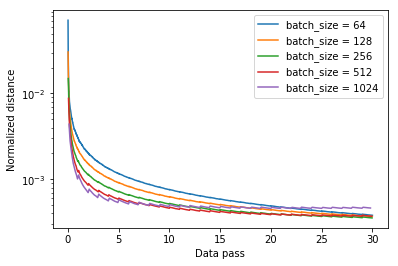

In [20]:
plt.clf()
plt.semilogy(np.arange(len(dist_mtx[0]))*64/9793,dist_mtx[0],label='batch_size = 64')
plt.semilogy(np.arange(len(dist_mtx[1]))*128/9793,dist_mtx[1],label='batch_size = 128')
plt.semilogy(np.arange(len(dist_mtx[2]))*256/9793,dist_mtx[2],label='batch_size = 256')
plt.semilogy(np.arange(len(dist_mtx[3]))*512/9793,dist_mtx[3],label='batch_size = 512')
plt.semilogy(np.arange(len(dist_mtx[4]))*1024/9793,dist_mtx[4],label='batch_size = 1024')
plt.xlabel('Data pass')
plt.ylabel('Normalized distance')
plt.legend()
plt.savefig('stability_logistic.png', format='png', dpi=1000)